# Feature Engineering On House Price Data Set





### Import required packages

In [1]:
# to handle datasets
import pandas as pd
import numpy as np


# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
# suppress some warning
pd.options.mode.chained_assignment = None  # default='warn'

# Add Imports here
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

### Load the data and Plot a Histogram of the SalePrice column

In [2]:
# load dataset from google drive
# there are some columns has categorical data named as 'NA', to remove 'NA' from default na_values
# will allow us to keep 'NA' as string instead of missing value
url = "https://drive.google.com/file/d/1saIeqrnkCHaZFqA8SHOwa4wb8xbxBGDi/view?usp=drive_link"
file_id = url.split('/')[-2]
filePath = 'https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(filePath,
                   na_values=[ '', '#N/A', '#N/A N/A', '#NA',#'NA'
                              '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN',
                              '<NA>', 'N/A', 'NULL','NaN', 'n/a', 'nan', 'null'],
                   keep_default_na=False)

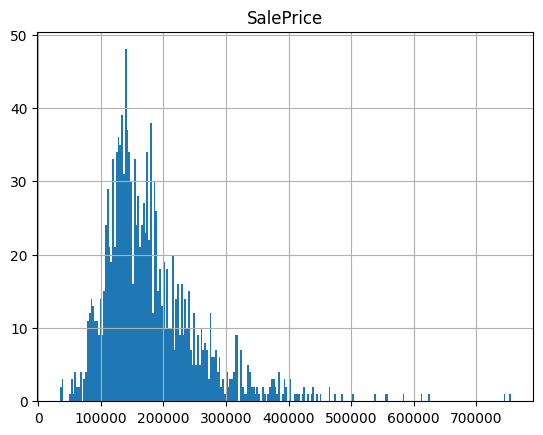

In [3]:
data.hist(column='SalePrice',  bins = 250)
plt.show()

### Distribution

The distribution of sales price is not normally distributed. We can prove it as below: <br>

Assume the SalePrice data is normally distributed as null hypothesis H0. In normal distribution,approximatly, 68% of data is one standard deviation (1std) away from the mean value, while 95% of data is 2std away, 97.5% of data is 3std away. 

Let the alternative hypothesis be H1. 

Set alpha value to be 0.05

In [4]:
# Test to check normality of the SalePrice column
# do a normality test

norm = pd.DataFrame({'Range':['|x-mean|<=std', 'std<|x-mean|<=2std', '2std<|x-mean|<=3std', '3std<|x-mean|'], 
                   'Percentage':[0.68, 0.27, 0.047, 0.003]}, index=['onestd', 'twostd', 'threestd', 'threestdOver'])
# calculate SalePrice relative frequency for the same data distribution
mean = data.SalePrice.mean() # calculate SalePrice mean value
print(f"Mean: {mean}")
std = data.SalePrice.std()  # calculate SalePrice standard deviation value
print(f"Standard deviation: {std}")
total = len(data.SalePrice)  # calculate the total number of observations
print(f"total observations: {total}"  )

onestd = 0
twostd = 0
threestd = 0
threestdOver = 0
for price in data.SalePrice:
    if abs(price - mean) <= std:
        onestd += 1
    elif std<abs(price - mean)<=2*std:
        twostd += 1
    elif 2*std<abs(price - mean)<=3*std:
        threestd += 1
    else:
        threestdOver +=1

priceFreq = [onestd, twostd, threestd, threestdOver]
norm['observedFreq'] = priceFreq
norm['ExpectedFreq'] = [i*total for i in norm.Percentage]
norm
## can use the chi-square testing the normal distribution. P alpha=5%

Mean: 180921.19589041095
Standard deviation: 79442.50288288662
total observations: 1460


,Range,Percentage,observedFreq,ExpectedFreq
onestd,|x-mean|<=std,0.680,1145,992.80
twostd,std<|x-mean|<=2std,0.270,252,394.20
threestd,2std<|x-mean|<=3std,0.047,41,68.62
threestdOver,3std<|x-mean|,0.003,22,4.38


In [5]:
stats.chisquare(norm.observedFreq, norm.ExpectedFreq)

Power_divergenceResult(statistic=156.6282410661729, pvalue=9.788843574336808e-34)

In [6]:
significance_level=0.05
chiStats, p = stats.chisquare(norm.observedFreq, norm.ExpectedFreq)
print(f"Chi-square stats: {chiStats}; p value: {p}")

if p < significance_level: 
    print('Reject NULL HYPOTHESIS, SalePrice is not normally distributed') 
else: 
    print('ACCEPT NULL HYPOTHESIS') 

Chi-square stats: 156.6282410661729; p value: 9.788843574336808e-34
Reject NULL HYPOTHESIS, SalePrice is not normally distributed


### Split data into Train and Test sub-datasets

In [7]:
### Split data into train and test sets 
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, # features or predictive variables
    y, # target
    test_size=0.3, # portion of dataset to allocate to test set
    random_state=10, # we are setting the seed here
)

X_train.shape, X_test.shape

((1022, 54), (438, 54))

### Create a list of all categorical variables

In [8]:
# Checking the type of each variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1201 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   Alley          91 non-null     object 
 3   LandContour    1460 non-null   object 
 4   BldgType       1460 non-null   object 
 5   HouseStyle     1460 non-null   object 
 6   OverallQual    1460 non-null   int64  
 7   OverallCond    1460 non-null   int64  
 8   YearBuilt      1460 non-null   int64  
 9   YearRemodAdd   1460 non-null   int64  
 10  RoofStyle      1460 non-null   object 
 11  MasVnrArea     1452 non-null   float64
 12  ExterQual      1460 non-null   object 
 13  ExterCond      1460 non-null   object 
 14  BsmtQual       1423 non-null   object 
 15  BsmtCond       1423 non-null   object 
 16  BsmtExposure   1422 non-null   object 
 17  BsmtFinType1   1423 non-null   object 
 18  BsmtFinS

In [9]:
# let's identify the categorical variables
# we will capture those of type object

cat_vars = X.select_dtypes(include=['object']).columns

# number of categorical variables
len(cat_vars)

19

### For X_train dataset, create a list of all categorical variables that contain missing data and print percentage of missing values per variable.

In [10]:
cat_vars_with_na=[]
for col in cat_vars:
    if data[col].isna().sum()>0:
        cat_vars_with_na.append(col)

print(cat_vars_with_na)

['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']


In [11]:
# make a list of the categorical variables that contain missing values
cat_vars_with_na=[]
for col in cat_vars:
    if data[col].isna().sum()>0:
        cat_vars_with_na.append(col)
print(f'Missing columns: {cat_vars_with_na} \n')

# print percentage of missing values per variable
percent_missing = X_train[cat_vars_with_na].isnull().sum() * 100 / len(X_train)
cat_missing_percent = pd.DataFrame({'column_name': cat_vars_with_na,
                                 'percent_missing': percent_missing}).sort_values('percent_missing', ascending=False)
print(cat_missing_percent)
#Code url: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
#Date accessed: 17-05-2022. 

Missing columns: ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence'] 

               column_name  percent_missing
Alley                Alley        93.444227
Fence                Fence        80.528376
FireplaceQu    FireplaceQu        46.868885
GarageFinish  GarageFinish         5.381605
GarageQual      GarageQual         5.381605
GarageCond      GarageCond         5.381605
BsmtQual          BsmtQual         2.544031
BsmtCond          BsmtCond         2.544031
BsmtExposure  BsmtExposure         2.544031
BsmtFinType1  BsmtFinType1         2.544031
BsmtFinType2  BsmtFinType2         2.544031


### For categorical variables with more than 10% of data missing, replace missing data with the word 'Missing', in other variables replace the missing data with the most frequent category in  the training set (Apply the replacement to X_train and X_test and make sure it is based on the results you have obtained from the training set).

In [12]:
# variables to impute with the string missing
with_string_missing = cat_missing_percent[percent_missing>10].index

# variables to impute with the most frequent category
with_frequent_category = cat_missing_percent[percent_missing<=10].index

In [13]:
print(with_string_missing)
print(with_frequent_category)

Index(['Alley', 'Fence', 'FireplaceQu'], dtype='object')
Index(['GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'],
      dtype='object')


In [14]:
# replace missing values in X_train and X_test with new label: "Missing"

#impute missing values for X_train   
X_train[with_string_missing]=X_train[with_string_missing].fillna('Missing')

#impute missing values for X_test
X_test[with_string_missing]=X_test[with_string_missing].fillna('Missing')



In [15]:
# replace missing values in X_train and X_test with the mode of each variable

#impute missing values for X_train
for col in with_frequent_category:
    Mode=X_train[col].mode()[0]
    X_train[col]=X_train[col].fillna(Mode)

#impute missing values for X_test
for col in with_frequent_category:
    Mode=X_test[col].mode()[0]
    X_test[col]=X_test[col].fillna(Mode)

In [16]:
# check that we have no missing information in the engineered variables
X_train[cat_vars_with_na].isnull().sum()

Alley           0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageFinish    0
GarageQual      0
GarageCond      0
Fence           0
dtype: int64

### Next, create a list of all numerical variables (do not include SalePrice)

In [17]:
# now let's identify the numerical variables
num_vars = X.select_dtypes(include=['int', 'float']).columns

# number of numerical variables
len(num_vars)

35

### Similarly, create a list of all numerical variables that contain missing data and print out the percentage of missing values per variable (use the training data).

In [18]:
# make a list with the numerical variables that contain missing values
vars_with_na = []
for col in num_vars:
    if X_train[col].isna().sum()>0:
        vars_with_na.append(col)

# print percentage of missing values per variable
num_percent_missing = X_train[vars_with_na].isnull().sum() * 100 / len(X_train)
num_missing_percent = pd.DataFrame({'column_name': vars_with_na,
                                 'num_percent_missing': num_percent_missing}).sort_values('num_percent_missing', ascending=False)
print(num_missing_percent)

             column_name  num_percent_missing
LotFrontage  LotFrontage            17.318982
GarageYrBlt  GarageYrBlt             5.381605
MasVnrArea    MasVnrArea             0.489237


### For numerical variables with less than 15% of data missing, replace missing data with the mean of the variable, in other variables replace the missing data with the median of the variable in the training set (Apply the replacement to X_train and X_test and make sure it is based on the results you have obtained from the training set).

In [19]:
# variables to impute with the median
with_mean = num_missing_percent[num_percent_missing<15].index
print(with_mean)
# variables to impute with the mean
with_median = num_missing_percent[num_percent_missing>=15].index
print(with_median)

Index(['GarageYrBlt', 'MasVnrArea'], dtype='object')
Index(['LotFrontage'], dtype='object')


In [20]:
# replace missing values as we described above
for col in with_mean:
    Mean=X_train[col].mean()
    X_train[col]=X_train[col].fillna(Mean)
    X_test[col]=X_test[col].fillna(Mean)
    
for col in with_median:    
    Median=X_train[col].median()
    X_train[col]=X_train[col].fillna(Median)
    X_test[col]=X_test[col].fillna(Median)           

In [21]:
# check that we have no more missing values in the engineered variables
X_test[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

### In the train and test sets, replace the values of variables 'YearBuilt', 'YearRemodAdd' and 'GarageYrBlt' with the time elapsed between them and the year in which the house was sold 'YrSold' and then drop the  'YrSold' column 

In [22]:
# columns to be replaced with time elapse from column value to "YrSold"
YrElapsed = ["YearBuilt", 'YearRemodAdd', 'GarageYrBlt']

In [23]:
# to calculate the time elapsed between YrElapsed variables and "YrSold":
def ToYrElapsed(df, cols):
    '''Add Docstring here.'''
    for col in cols:
        df[col]=df['YrSold']-df[col]    


In [24]:
ToYrElapsed(X_train,YrElapsed)
ToYrElapsed(X_test,YrElapsed)

In [25]:
# now we drop YrSold
X_train.drop(['YrSold'], axis=1, inplace=True)
X_test.drop(['YrSold'], axis=1, inplace=True)

In [26]:
X_train.head(3)

,LotFrontage,LotArea,Alley,LandContour,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold
912,51.0,6120,Missing,Lvl,1Fam,1Story,5,7,81,56,Gable,0.0,TA,TA,TA,TA,No,Rec,489,Unf,0,279,768,TA,1015,0,0,1015,0,0,1,0,3,1,TA,6,0,Missing,81.0,Unf,1,450,TA,TA,0,0,112,0,120,0,MnPrv,620,7
373,79.0,10634,Missing,Lvl,1Fam,1Story,5,6,56,56,Gable,0.0,TA,TA,TA,TA,No,BLQ,428,LwQ,180,0,608,TA,1319,0,0,1319,1,0,1,0,3,1,TA,5,0,Missing,56.0,Unf,1,270,TA,TA,66,0,0,0,0,0,GdWo,0,11
20,101.0,14215,Missing,Lvl,1Fam,2Story,8,5,1,0,Gable,380.0,Gd,TA,Ex,TA,Av,Unf,0,Unf,0,1158,1158,Ex,1158,1218,0,2376,0,0,3,1,4,1,Gd,9,1,Gd,1.0,RFn,3,853,TA,TA,240,154,0,0,0,0,Missing,0,11


### Apply mappings to categorical variables that have an order 

Some of the categorical variables have values with an assigned order (in total there should be 14 of them), related to quality (For more information, check the data description file). This means, we can replace categories by numbers to determine quality. For example, values in the 'BsmtExposure' can be mapped as follows: 'No' can be mapped to 1, 'Mn' can be mapped to 2, 'Av' can be mapped to 3 and 'Gd' can be mapped to 4. 

One way of doing this is to manually create mappings similar to the example given. Each mapping can be saved as a Python dictionary and used to perform the actual mapping to transform the described variables from categorical to numerical.

To Make it easier for you, here are groups of variables that have the same mappings (Hint: you can map both categories 'Missing' and 'NA' to 0): 

- The following variable groups have the same mapping: 
    - ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu','GarageQual', 'GarageCond']
    - ['BsmtFinType1', 'BsmtFinType2']

- Each of the following variables has its own mapping: 'BsmtExposure', 'GarageFinish', 'Fence'

In [27]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond'
            ]


## Loop through the variables and apply the mapping here
# Apply mapping on the train and test sets
def mapToNum(df,cols,mappings):
    '''Add Docstring here.'''    
    for col in cols:
        df[col]=df[col].map(mappings)

mapToNum(X_train, qual_vars, qual_mappings)
mapToNum(X_test, qual_vars, qual_mappings)

In [28]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'
var_list = ['BsmtExposure']
# Apply mapping on the train and test sets
mapToNum(X_train, var_list, exposure_mappings)
mapToNum(X_test, var_list, exposure_mappings)


In [29]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

# Apply mapping on the train and test sets
mapToNum(X_train, finish_vars, finish_mappings)
mapToNum(X_test, finish_vars, finish_mappings)


In [30]:
X_train['GarageFinish'].value_counts()

GarageFinish
Unf    468
RFn    301
Fin    253
Name: count, dtype: int64

In [31]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

# Apply mapping on the train and test sets
var_garage = ['GarageFinish']
mapToNum(X_train, var_garage, garage_mappings)
mapToNum(X_test, var_garage, garage_mappings)

In [32]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

# Apply mapping on the train and test sets
var_fence = ['Fence']
mapToNum(X_train, var_fence, fence_mappings)
mapToNum(X_test, var_fence, fence_mappings)

In [33]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

### Replace Rare Labels with 'Rare'

For the remaining five categorical variables (the variables that you did not apply value mappings to, they should be five variables), you will need to group those categories that are present in less than 1% of the observations in the **training set**. That is, all values of categorical variables that are shared by less than 1% of houses in the training set will be replaced by the string "Rare" in both the training and test set. 

- Find rare labels in the remaining categorical variables and replace them with the category 'Rare'.
- Rare labels are those categories that only appear in a small percentage of the observations (in our case in < 1%).
- If you look at unique values in a categorical variable in the training set and count how many times each of the unique values appear in the variable, you can compute the percentage of each unique value by dividing its count by the total number of observations.
- Remember to make the computions using the training set and replacement in both training and test sets.

In [34]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

5

In [35]:
# create a list matching the categories less than 1% frequent to string "Rare"
rare=[]
for col in cat_others:    
    find = X_train[col].value_counts()*100/len(X_train[col])
    for i in range(len(find)):
        if find[i]<1:
            Loc = find.index[i]
            rare.append(Loc)
            
print(rare)            

['1.5Unf', '2.5Unf', '2.5Fin', 'Gambrel', 'Flat', 'Mansard', 'Shed']


In [36]:
# Apply replacement on the train and test sets
for col in cat_others:
    for i in rare:
        X_train[col].replace(i, 'Rare',inplace=True)

for col in cat_others:
    for i in rare:
        X_test[col].replace(i,'Rare', inplace=True) 

In [37]:
# for col in cat_others:    
#     find = X_train[col].value_counts()*100/len(X_train[col])
#     OnePercent=find[find<1].index
#     print([var for var in OnePercent if var != []])

### One hot encoding of categorical variables 
Perform one hot encoding to transform the previous five categorical variables into binary variables. Make sure you do it correctly for both the training and testing sets. After this, remember to drop the original five categorical variables (the ones with the strings) from the training and test after the encoding.

In [38]:
# # one hot encoding for X_train
# for col in cat_others:
#     col_cats=X_train[col].unique()
#     var_to_int = dict((v,i) for i,v in enumerate(col_cats))
#     int_to_var = dict((i,v) for i,v in enumerate(col_cats))
#     ColIndexing = [var_to_int[var] for var in X_train[col]]

#     OHE=[]
#     for i in ColIndexing:
#         vector = [0 for i in range(1,len(col_cats))]
#         #print(vector)
#         if i == 0:
#             vector[i]=0
#         else:
#             vector[i-1]=1

#         var=int_to_var[i]
#         OHE.append(vector)
#     X_train['OHE %s ' % col]=OHE             
# X_train.drop(cat_others, axis=1, inplace=True)
# X_train.head(2) 

In [39]:
ohe=pd.get_dummies(X_train[cat_others], prefix=cat_others, drop_first=True)
X_train=pd.concat([X_train,ohe], axis=1)

In [40]:
X_train.drop(cat_others, axis=1, inplace=True)

In [41]:
X_train.head(1)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,Alley_Missing,Alley_Pave,LandContour_HLS,LandContour_Low,LandContour_Lvl,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Rare,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Hip,RoofStyle_Rare
912,51.0,6120,5,7,81,56,0.0,3,3,3,3,1,3,489,1,0,279,768,3,1015,0,0,1015,0,0,1,0,3,1,3,6,0,0,81.0,1,1,450,3,3,0,0,112,0,120,0,3,620,7,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False


In [42]:
test_ohe=pd.get_dummies(X_test[cat_others], prefix=cat_others, drop_first=True)
X_test=pd.concat([X_test,test_ohe], axis=1)

In [43]:
X_test.drop(cat_others, axis=1, inplace=True)

In [44]:
X_test.head(1)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,Alley_Missing,Alley_Pave,LandContour_HLS,LandContour_Low,LandContour_Lvl,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Rare,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Hip,RoofStyle_Rare
854,102.0,17920,5,4,51,32,0.0,3,3,3,3,2,5,306,3,1085,372,1763,3,1779,0,0,1779,1,0,1,1,3,1,3,6,1,4,51.0,1,2,454,3,3,0,418,0,0,312,0,0,0,7,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False


In [45]:
X_train.columns==X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [46]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [47]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

### Feature Scaling
Now we know all variables in our two datasets (i.e. the training and test sets) are numerical, the final step in this exercise is to apply scaling by making sure the minimum value in each variable is 0 and the maximum value is 1. For this step, you can use MinMaxScaler() from sci-kit learn. Make sure you apply it correctly by transforming the test set based on the training set. 

In [48]:
# Make sure you do it correctly
scaler=MinMaxScaler()
m=scaler.fit(X_train)
X_train=m.transform(X_train)
X_test=m.transform(X_test)

In [49]:
print(X_train.mean().mean())
print(X_test.mean().mean())

0.24977436797009805
0.24727781373321087
